# Task 3 Confounders in AI
## Outline
1. Introduction to Confounders
- Definition
- Importance, why are they significant in AI and how can they influence outcomes
2. Confounders in AI
- Impact on AI models, how can confounders affect accuracy and reliability
- Examples, where confounders notably skewed AI model results
3. Addressing Confounders
- Methods of adjustment, common techniques
- Benefits of addressing confounders
4. Case Study 
- Select a technique to Adjust for confounders
- Discuss the techniques application
- Discussion and Example of this techniwue applied in a real AI project
5. Conclusion
- Summary
- Implications for future AI Development


## Sources
1. Pneumothorax Detection in Chest Radiographs:
- Link: [PDF](../../Books/s00330-021-07833-w.pdf)
- Summary: How can AI models be affected by noisy data and confounders focusing on medical imaging
2. Uncovering Interpretable Potential Confounders in Electronic Medical Records:
- Link: [PDF](../../Books/s41467-022-28546-8.pdf)
- Summary: Methods to uncover potential confounders in AI within healthcare, emphasizing interoretability
3. Confounders Mediate AI Prediction of Demographics in Medical Imaging:
- Link: [PDF](../../Books/s41746-022-00720-8.pdf)
- Summary: Role of confounders in skewing AI predictions
4. Measuring the Effects of Confounders in Medical Supervised Classification Problems: The Confounding Index (CI):
- Link: [PDF](../../Books/1-s2.0-S0933365719303410-main.pdf)
- Summary: Introduces the Confounding Index to measure the impact of confounders in machine learning models
5. Dealing with Confounders and Outliers in Classification Medical Studies:
- Link: [PDF](../../Books/1-s2.0-S0933365719306086-main.pdf)
- Summary: Methods to identify variables that could be confounders to the learning process in medical AI studies

## Example
### Scenario - Predicting Diabetes
Cardiovascular disease (CVD) is a leading cause of death globally. Accurate predictions are curcial for early intervention. There are many models attempting to predict CVD based on various patient data points.
A potential confounder in these models can be the smoking status of a patient. Smoking is a known risk factor for CVD but it also correlates with other lifestyle factors such as diet, exercise, or socioeconomic status, which can independently affect CVD.

Our goal is to adjust for smoking as a confounder to accurately assess the effect of other variables like cholesterol levels, blood pressure or BMI on CVD risk.

(We will develop a logistic linear regression model either showing risk or no risk for CVD)

In [142]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

from causalml.match import NearestNeighborMatch

from dowhy import CausalModel

In [162]:
# Random data generation (this data will not be representative, it only serves the purpose of showing the potential influence of confounders on machine learning models)
np.random.seed(73)
datasize = 1000
smoking = np.random.binomial(1, 0.3, datasize) # generate smoking data with 30% smokers
cholesterol_level = np.where(smoking == 1, np.random.normal(220, 25, datasize), np.random.normal(190, 25, datasize)) # generate cholesterol level data, where smokers cholesterol level mean is higher
cvd_risk = np.random.binomial(1, 1 / (1 + np.exp(-0.04 * (cholesterol_level - 200) - 0.6 * smoking)), datasize)
data = pd.DataFrame({'smoking': smoking, 'cholesterol_level': cholesterol_level, 'cvd_risk': cvd_risk})

print(data.head())
print("CVD Risk Distribution:", data['cvd_risk'].mean())

   smoking  cholesterol_level  cvd_risk
0        0         231.462802         1
1        0         172.016685         0
2        0         201.332775         1
3        0         144.779904         0
4        0         202.143204         1
CVD Risk Distribution: 0.536


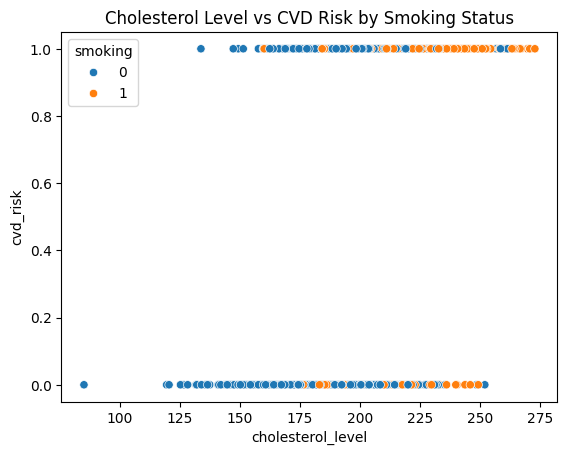

In [144]:
# Scatterplot of cholesterol level vs cvd risk colored by smoking status
sns.scatterplot(data=data, x='cholesterol_level', y='cvd_risk', hue='smoking')
plt.title('Cholesterol Level vs CVD Risk by Smoking Status')
plt.show()

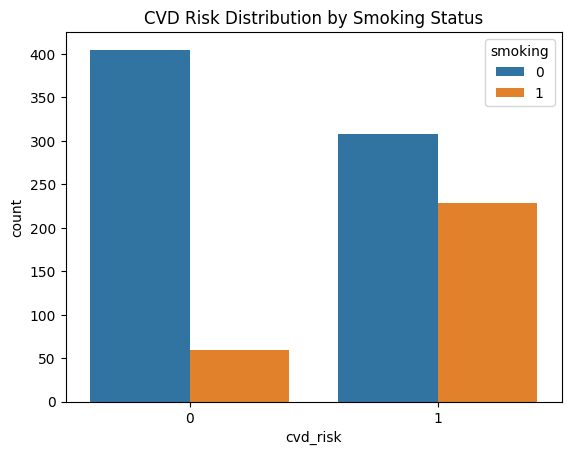

In [145]:
# Histogram of cvd risk
sns.countplot(data=data, x='cvd_risk', hue='smoking')
plt.title('CVD Risk Distribution by Smoking Status')
plt.show()

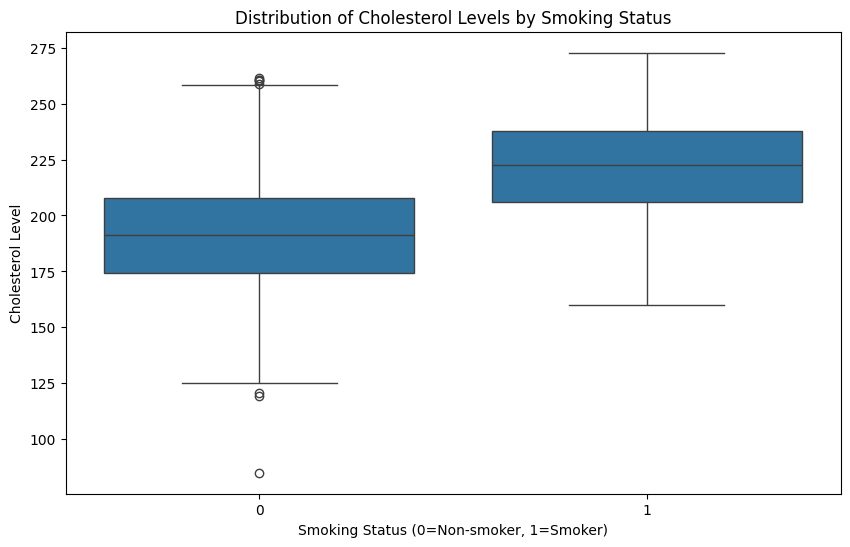

In [152]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoking', y='cholesterol_level', data=data)
plt.title('Distribution of Cholesterol Levels by Smoking Status')
plt.xlabel('Smoking Status (0=Non-smoker, 1=Smoker)')
plt.ylabel('Cholesterol Level')
plt.show()

In [146]:
# model without smoking
X = data[['cholesterol_level']]
y = data['cvd_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

model = LogisticRegression()
model.fit(X_train, y_train)
preds_cholesterol = model.predict(X_test)
roc_auc = roc_auc_score(y_test, preds_cholesterol)
print("ROC AUC without smoking:", roc_auc)

ROC AUC without smoking: 0.7249999999999999


In [147]:
# model without smoking
X = data[['smoking']]
y = data['cvd_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

model = LogisticRegression()
model.fit(X_train, y_train)
preds_smoking = model.predict(X_test)
roc_auc = roc_auc_score(y_test, preds_smoking)
print("ROC AUC without cholesterol_level:", roc_auc)

ROC AUC without cholesterol_level: 0.665


In [148]:
# Model with smoking as a confounder
X = data[['cholesterol_level', 'smoking']]
y = data['cvd_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

model = LogisticRegression()
model.fit(X_train, y_train)
preds_both = model.predict(X_test)
roc_auc = roc_auc_score(y_test, preds_both)
print("ROC AUC with smoking and cholesterol:", roc_auc)

ROC AUC with smoking and cholesterol: 0.75


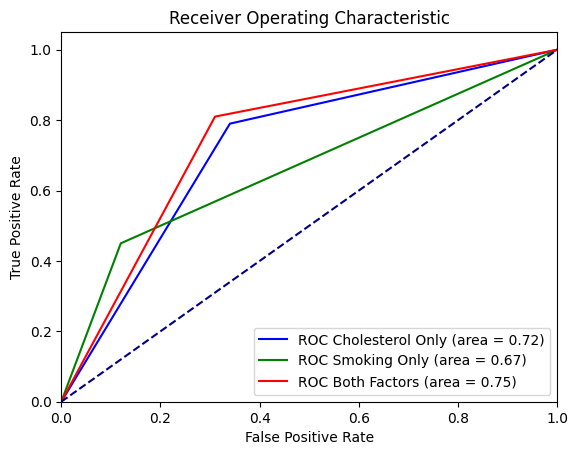

In [149]:
fpr_c, tpr_c, _ = roc_curve(y_test, preds_cholesterol)
fpr_s, tpr_s, _ = roc_curve(y_test, preds_smoking)
fpr_b, tpr_b, _ = roc_curve(y_test, preds_both)

roc_auc_c = auc(fpr_c, tpr_c)
roc_auc_s = auc(fpr_s, tpr_s)
roc_auc_b = auc(fpr_b, tpr_b)

plt.figure()
plt.plot(fpr_c, tpr_c, color='blue', label='ROC Cholesterol Only (area = %0.2f)' % roc_auc_c)
plt.plot(fpr_s, tpr_s, color='green', label='ROC Smoking Only (area = %0.2f)' % roc_auc_s)
plt.plot(fpr_b, tpr_b, color='red', label='ROC Both Factors (area = %0.2f)' % roc_auc_b)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Interpretation of Results
We can observe that the ROC AUC Score improves if we include smoking in the model. This suggests that smoking improves the models accuracy by accounting for its confounding effect.

### DoWhy
1. Model Specification: Define a causal graph or model that specifies the relationship among all relevant variables.
2. Identification of Causal Effect: Try to identify the causal effect of the treatment on the outcome, explicitly taking the confounders into account
3. Estimation: doWhy uses a variety of statistical methods to estimate the effect. 
4. Refutation: Optional tests to check if identified causal effect is robust


In [150]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define the causal model
model = CausalModel(
    data=data,
    treatment='cholesterol_level',
    outcome='cvd_risk',
    common_causes=['smoking']
)

# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the causal effect
estimate = model.estimate_effect(identified_estimand, method_name='backdoor.linear_regression', test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

# Refute the estimate
refute_results = model.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')
print(refute_results)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                              
───────────────────(E[cvd_risk|smoking])
d[cholesterolₗₑᵥₑₗ]                     
Estimand assumption 1, Unconfoundedness: If U→{cholesterol_level} and U→cvd_risk then P(cvd_risk|cholesterol_level,smoking,U) = P(cvd_risk|cholesterol_level,smoking)

## Realized estimand
b: cvd_risk~cholesterol_level+smoking
Target units: ate

## Estimate
Mean value: 0.007330015338747997
p-value: [2.2372317e-36]

Causal Estimate is 0.007330015338747997
Refute: Add a random common cause
Estimated effect:0.007330015338747997
New effect:0.007328447781707315
p value:0.98



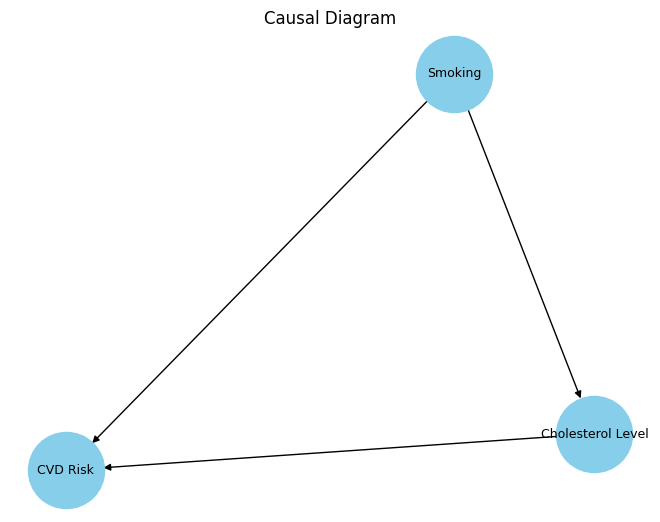

In [167]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes with the node attribute "label"
nodes = ["Cholesterol Level", "Smoking", "CVD Risk"]
G.add_nodes_from(nodes)

# Add edges
edges = [("Smoking", "Cholesterol Level"), ("Cholesterol Level", "CVD Risk"), ("Smoking", "CVD Risk")]
G.add_edges_from(edges)

# Position nodes using the layout for directed graphs
pos = nx.layout.spring_layout(G)

# Draw the network
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='k', linewidths=1, font_size=9)

# Show plot
plt.title('Causal Diagram')
plt.show()

## Interpretations
### Causal Diagram
The causal diagram is a visual representation of the assumed relationships among cholesterol level, smoking status and cardiovascular disease (CVD) risk.
- Cholesterol level and smoking both directly influence CVD Risk.
- Smoking also influences the cholesterol level, which also affects the CVD risk.

This setup suggests that smoking could act as a confounder in the relationship beteen cvd risk and cholesterol level.

### Causal Estimate (DoWhy analysis)
- Identified Estimand (Backdoor Criterion): We realize there is a pathway through which cholesterol level influences CVD risk and recognizes smoking as a common cause that needs to be adjusted for to isolate the effect of cholesterol levels on CVD risk.
- Causal Effect Estimate: 
* Mean suggests a relatively small direct effect of cholesterol levels on CVD risk when smoking is controlled for.
* P-value is extremely low and indicates that the observed effect is statistically significant. 
- Refutation Test: It introduces a new random variable into the analysis to check whether the causal estimate is sensitive to changes in the data that could represent unobserved confounding. In this case the effect and is near identical and the p-value high, indicating that the causal estimate is robust. 

#### Model Reliability
The results indicate that the model is reliable and that the effect of cholesterol on CVD risk is consistent even when potentially confounding variables are considered. 

#### Model Interpretability
By adjusting for confounders like smoking, the model ehances its interpretability. We can be more confident that the relationship between cholesterol and CVD risk is not spurious and indeed indicative of a possible causal connection. 


## Summary
* Accuracy of Predictions: By adjusting for smoking in the analysis of cholesterol levels and CVD risk, we ensured that the model accurately attributes effects to the right causes, avoiding misleading conclusions that could arise from omitted variable bias.
* Reliability in High-Stakes Decisions: In healthcare, where decisions can significantly impact patient outcomes, ensuring that models are reliable and based on robust causal relationships is critical. Our analysis demonstrated how controlling for confounders like smoking leads to more reliable assessments of risk factors.
* Uncovering Subtle Effects: The inclusion of smoking as a confounder allowed us to detect a statistically significant, albeit small, direct effect of cholesterol on CVD risk. This illustrates that even subtle influences, which are often overlooked, can be crucial for understanding complex health conditions.
* Prevention of Spurious Correlations: Directly adjusting for confounders helps prevent the model from mistaking correlation for causation—a common pitfall in machine learning applications that can lead to inappropriate strategies and interventions.
* Enhanced Interpretability: Models that account for confounders enhance the interpretability of their outputs, enabling healthcare professionals to trust and effectively use machine learning insights in clinical settings.
* Robustness Against Misleading Data Relationships: Our refutation tests showed that the causal estimates remained stable even with the introduction of a random common cause, underscoring the robustness of our findings against potential unobserved confounding.

# Paper Sketch
## Outline
### 1. Introduction to Confounders
#### - Definition: 
Clarify what confounders are—variables that influence both the dependent and independent variables, leading to potential bias in the estimation of the effect of the independent variable.
#### - Importance: 
Explain why confounders are critical in AI:
* They can lead to biased results and erroneous conclusions if not properly accounted for.
* Addressing them enhances the accuracy and reliability of AI predictions, particularly in healthcare.
### 2. Confounders in AI
#### - Impact on AI Models:
* Confounders can skew the relationships models learn, affecting their ability to generalize and potentially leading to incorrect decisions.
* Examples of AI systems failing in real-world applications due to ignored confounders.
#### - Examples:
Case studies from published research where not addressing confounders led to significantly different outcomes.
### 3. Addressing Confounders
#### - Methods of Adjustment:
* Common techniques such as stratification, matching, regression adjustment, and more sophisticated methods like propensity score matching.
* Use of causal inference frameworks, like doWhy, to explicitly model and adjust for confounders.
#### - Benefits:
* Improved model integrity and decision-making accuracy.
* Enhanced credibility and acceptance of AI systems among users and stakeholders.
### 4. Case Study
#### - Technique Selection:
* Choose propensity score matching as the technique for adjusting confounders, explaining its applicability and effectiveness.
Technique Application:
* Detailed step-by-step description of applying propensity score matching to the synthetic dataset involving cholesterol, smoking, and CVD risk.
* Discussion and Example Application:
* Results of the case study, including ROC AUC scores and causal estimates.
* Visualization of the causal relationship using NetworkX and its impact on understanding the data.
### 5. Conclusion
#### - Summary:
* Recap the importance of confounder adjustment, key findings from the case study, and how the example illustrates broader implications for AI development.
* Implications for Future AI Development:
The need for integrating causal analysis in the AI model development process.
Suggestions for ongoing research to explore additional confounders and extend findings to more complex and varied datasets.